v0.1 (04/11/24)

## NeuroMotor Project

In [2]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from tqdm.notebook import trange, tqdm

import scipy.signal as sig

path_all = '../RepositoryData'
# plt.style.use('seaborn-v0_8-bright')


In [3]:
single_subject = path_all + '/SL01-T01'
sgl_subj_eeg = single_subject + '/eeg.txt'

In [4]:
# # check the path
# !ls -l $path_all

In [5]:
# the data we want from 2min to 17min with fs = 100Hz
t_walk_min = [2, 17]
t_first_5=[2,7]
t_first_ten=[2,12]
t_stand_min = [0, 2]
t_walkBCI_min = [17, 22]
t_stand_min_2 = [22, 24]

fs = 100

# Seperates into time periods for walking so that data scarcity can be simulated later
t_walk_data = {'t_start_walk': t_walk_min[0]*60*fs, 't_end_walk': t_walk_min[1]*60*fs}
t_walk_data5 = {'t_start_walk': t_first_5[0]*60*fs, 't_end_walk': t_first_5[1]*60*fs}
t_walk_data10 = {'t_start_walk': t_first_ten[0]*60*fs, 't_end_walk': t_first_ten[1]*60*fs}

# Data that probably wont be used but good to have handel for
t_stand_data = {'t_start_stand': t_stand_min[0]*60*fs, 't_end_stand': t_stand_min[1]*60*fs}
t_walkBCI_data = {'t_start_walkBCI': t_walkBCI_min[0]*60*fs, 't_end_walkBCI': t_walkBCI_min[1]*60*fs}
t_stand_data_2 = {'t_start_stand_2': t_stand_min_2[0]*60*fs, 't_end_stand_2': t_stand_min_2[1]*60*fs}

# all non-BCI data (probably wont be used)
t_useful_data = {'t_start_useful_1': t_stand_data['t_end_stand'], 't_end_useful_1': t_walk_data['t_start_walk'], 't_start_useful_2': t_stand_data_2['t_end_stand_2']}

In [6]:
# Load the data
eeg = pd.read_csv(sgl_subj_eeg, sep='\t', on_bad_lines='warn', skiprows=1, header=None)
eeg.dropna(axis=1, how='all', inplace=True)

# first column is the time in seconds
time = eeg.iloc[:, 0]
eeg = eeg.iloc[:, 1:]

# drops unwanted sections
eeg_walk=eeg.drop(range(t_walk_data['t_start_walk']))
eeg_walk=eeg_walk.drop(range(t_walk_data['t_end_walk']-1, eeg_walk.index[-1]))
eeg_walk = eeg_walk.to_numpy()
perform_drop=len(eeg_walk)==t_walk_data['t_end_walk']- t_walk_data['t_start_walk']

# checks to make sure desired rows were dropped
if perform_drop:
    print('Drop successful')
else:
    print('Length of array is: ' + str(len(eeg_walk)))
    print(' but is supposed to be '+ str(t_walk_data['t_end_walk']- t_walk_data['t_start_walk']))

# For general checking of data:
# eeg = eeg.to_numpy()
# time = time.to_numpy()
# print(eeg.shape, time.shape)

print("Time shape: ", time.shape)
print("EEG shape: ", eeg.shape)

Drop successful
Time shape:  (137242,)
EEG shape:  (137242, 64)


## PCA

In [19]:
max_num_components = 25

num_components = range(1, max_num_components + 1)
total_variance = []

pca = decomposition.PCA(n_components=max_num_components)
pca.fit(eeg)

for i in tqdm(num_components):
    variance = np.sum(pca.explained_variance_ratio_[:i])
    total_variance.append(variance)
# variance = np.sum(pca.explained_variance_ratio_)
# total_variance.append(variance)

  0%|          | 0/25 [00:00<?, ?it/s]

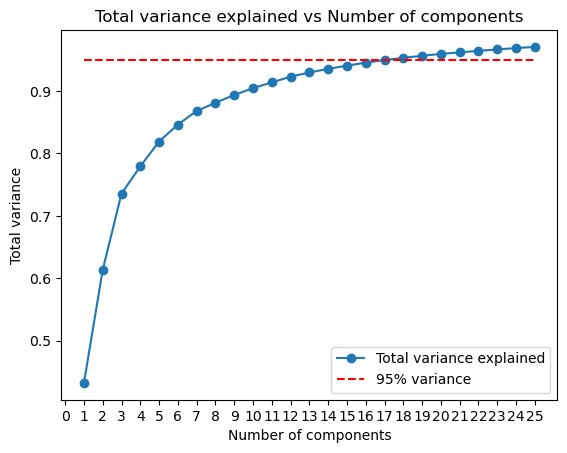

Number of components needed to explain 95% variance:  18


In [20]:
plt.plot(num_components, total_variance, marker='o', label='Total variance explained')
plt.plot(num_components, [.95 for _ in num_components], linestyle='--', color='r', label='95% variance')
plt.xlabel('Number of components')
plt.ylabel('Total variance')
plt.title('Total variance explained vs Number of components')
plt.legend()
plt.xticks(range(0,26))
plt.show()

above_95 = [i for i, v in enumerate(total_variance) if v > 0.95]
print("Number of components needed to explain 95% variance: ", num_components[above_95[0]])


## ICA

### Donovan's Attempt At ICA

ICA components shape:  (137242, 64)


/home/donovan/miniconda3/envs/neuromotor-capstone/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


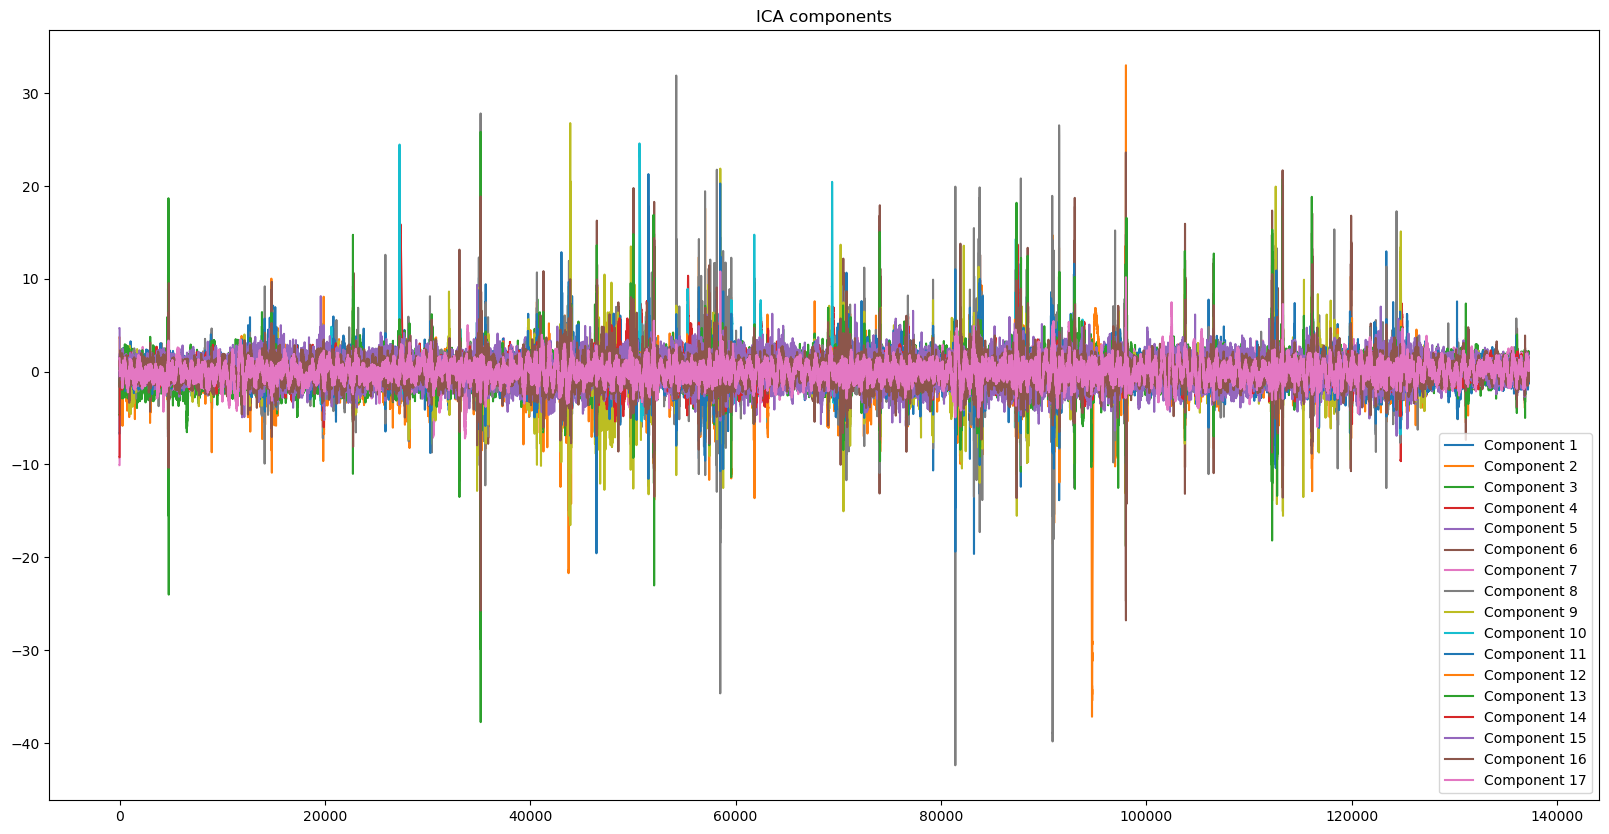

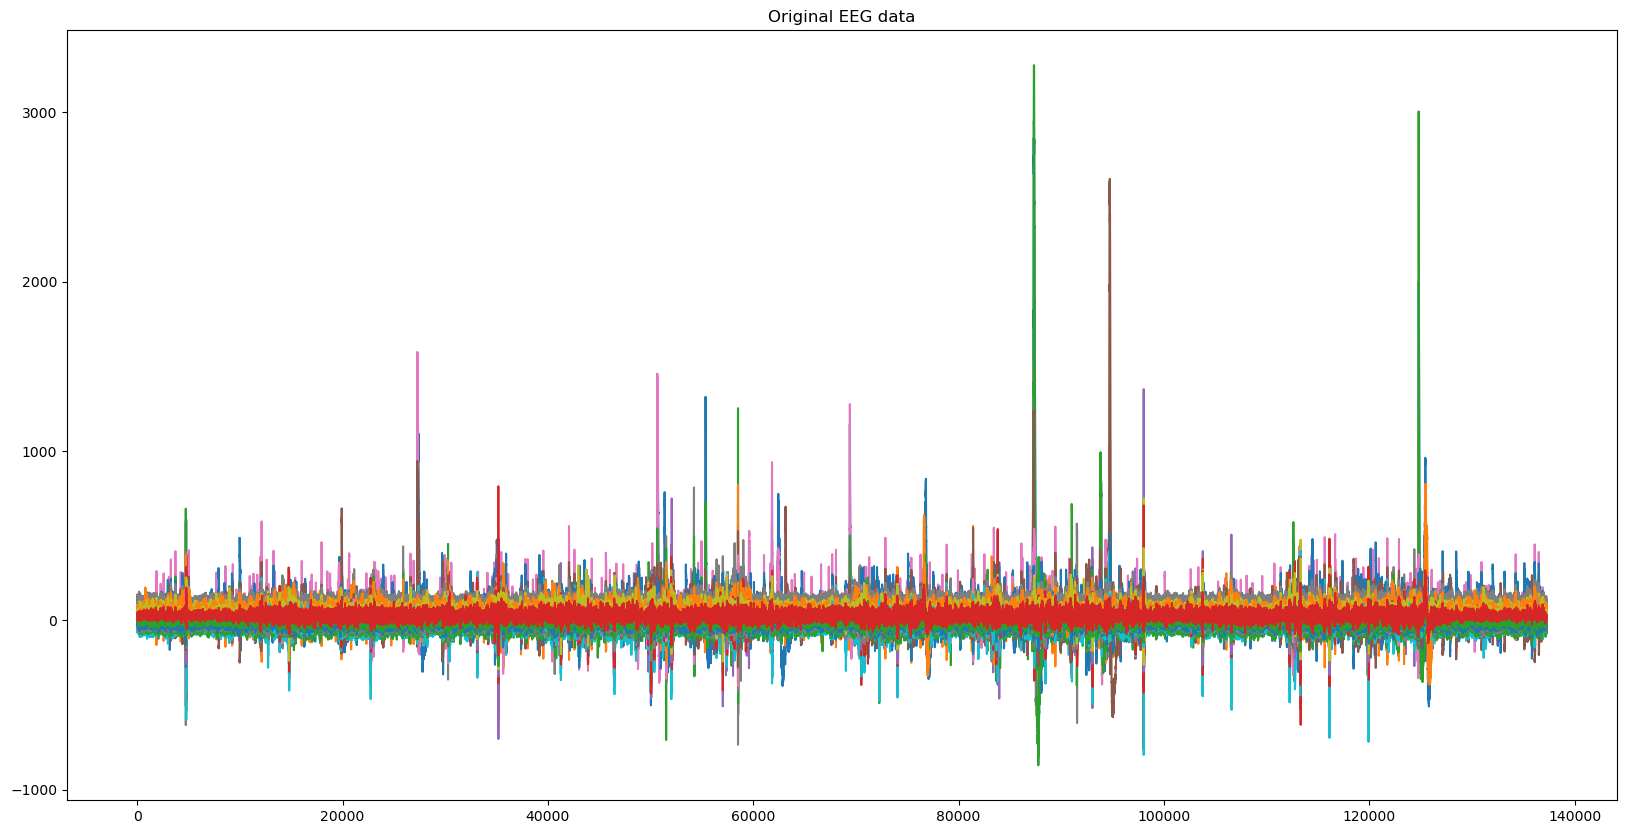

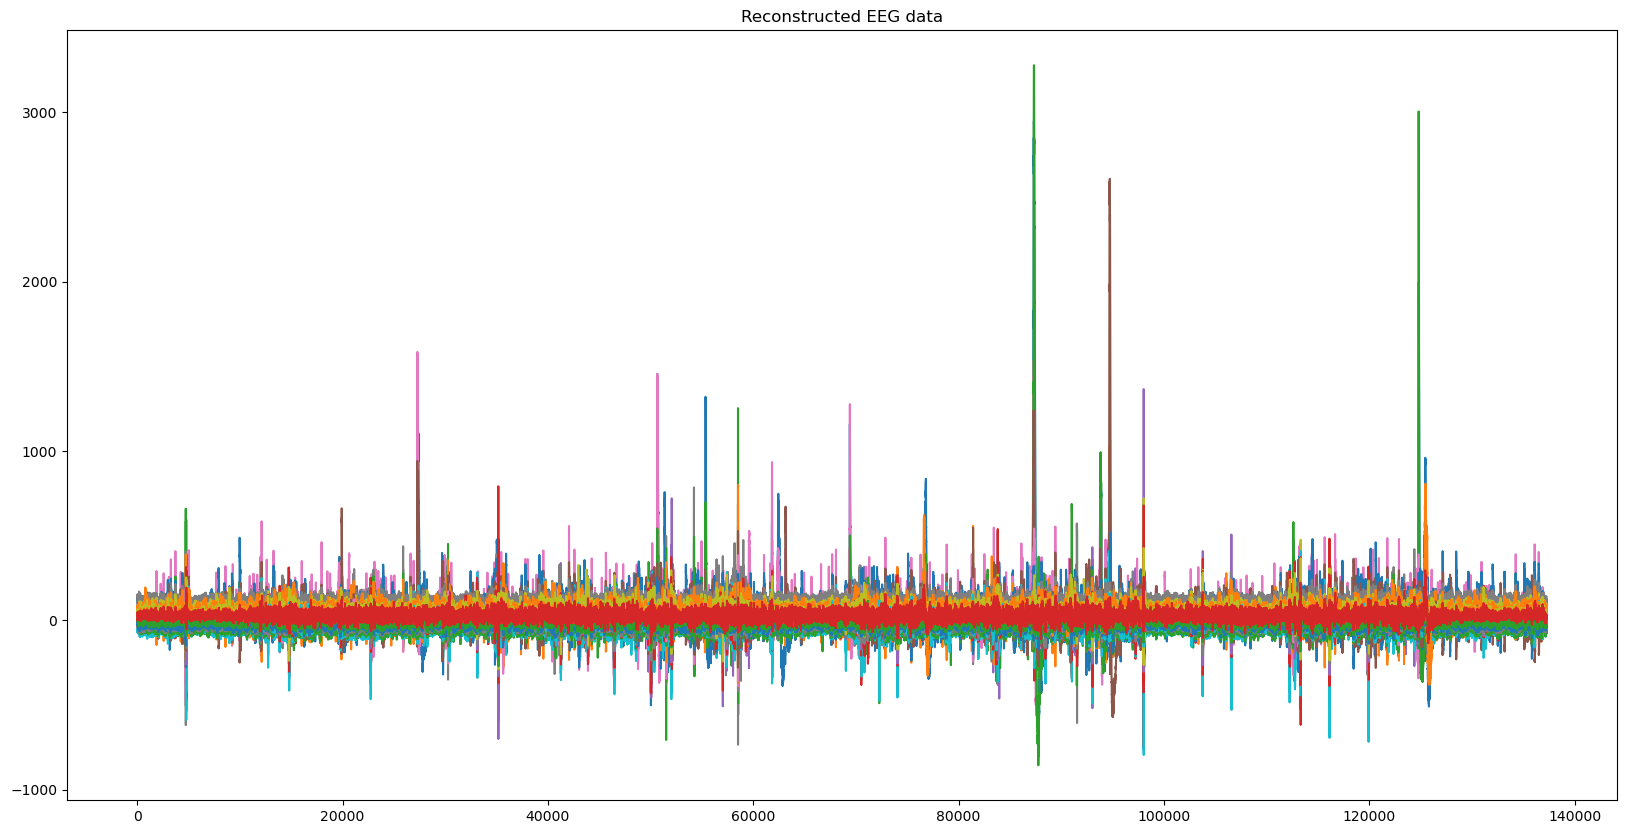

In [45]:
ica = decomposition.FastICA()
eeg_ica = ica.fit_transform(eeg)
# eeg_ica = ica.transform(eeg)

print("ICA components shape: ", eeg_ica.shape)

# Plot the ICA components
plt.figure(figsize=(20, 10))
for i in range(above_95[0]):
    plt.plot(eeg_ica[:, i], label=f'Component {i+1}')
plt.legend()
plt.title('ICA components')
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(eeg)
plt.title('Original EEG data')
plt.show()

# Check if the ICA components can be transformed back to the original data
eeg_reconstructed = ica.inverse_transform(eeg_ica)
plt.figure(figsize=(20, 10))
plt.plot(eeg_reconstructed)
plt.title('Reconstructed EEG data')
plt.show()


In [48]:
print(np.allclose(eeg, eeg_ica))

False


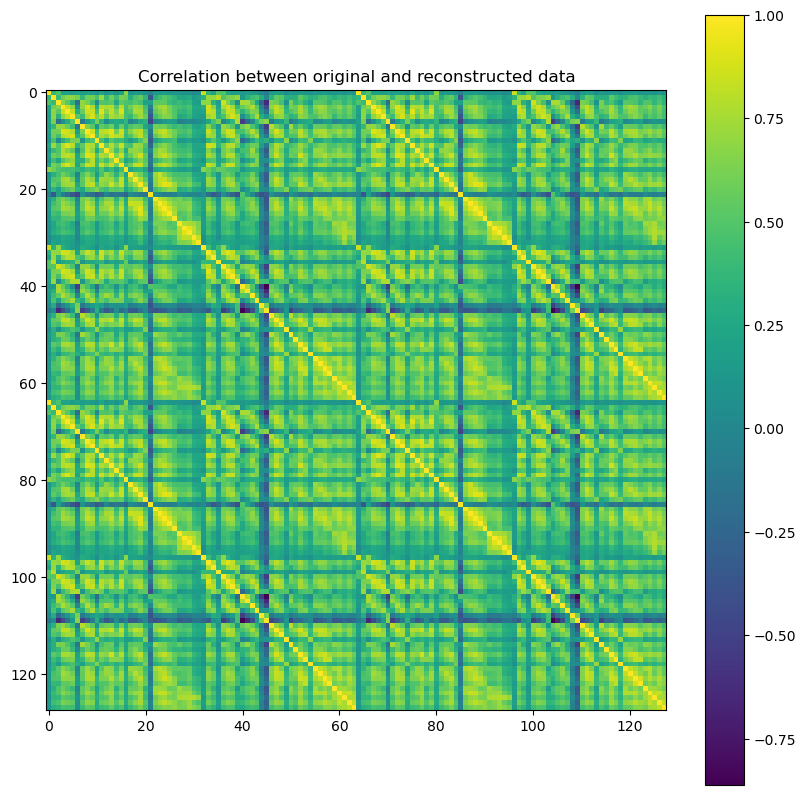

In [46]:

# Check the correlation between the original and reconstructed data
correlation = np.corrcoef(eeg.T, eeg_reconstructed.T)
plt.figure(figsize=(10, 10))
plt.imshow(correlation, cmap='viridis')
plt.colorbar()
plt.title('Correlation between original and reconstructed data')
plt.show()

### Heather's Attempt at ICA

In [25]:
# Start with normalizing the data with regard to independent variable
scaler = StandardScaler()
eeg_norm = scaler.fit_transform(eeg)

In [26]:
# Loading dependent variable
sgl_joint_angl=single_subject+'/joints.txt'

# Remove the first 2 lines of the file using skiprows
j_angl = pd.read_csv(sgl_joint_angl, sep='\t', header=None ,names=list(range(14)), skiprows=2)

In [27]:
# processing data
j_angl.dropna(axis=1, how='all', inplace=True)
# first column is the time in seconds
j_time = j_angl.iloc[:, 0]
j_angl = j_angl.drop(0, axis=1)
j_angl = j_angl.drop(range(7,13), axis=1)
print(j_angl.head())

      1      2      3     4      5     6
0  1.44 -6.435 -3.375 -1.26  1.125  3.06
1  1.44 -6.435 -3.375 -1.26  1.125  3.06
2  1.44 -6.435 -3.375 -1.26  1.125  3.06
3  1.44 -6.435 -3.375 -1.26  1.125  3.06
4  1.44 -6.435 -3.375 -1.26  1.125  3.06


In [28]:
# selects sections we want from joint data
j_walk=j_angl.drop(range(t_walk_data['t_start_walk']))
j_walk=j_walk.drop(range(t_walk_data['t_end_walk']-1, j_walk.index[-1]))
j_walk = j_walk.to_numpy()

In [29]:
# Electrode labeling

# Loading electrode labels
sgl_ele_labels=single_subject+'/impedances-before.txt'

# Remove the first 2 lines of the file using skiprows
ele_imp = pd.read_csv(sgl_ele_labels, sep='\t', header=None , skiprows=20, names=list(range(5)))

ele_labels=ele_imp[1]
ele_labels=ele_labels.drop(0)


EOG_labels=[' TP9', 'TP10', ' FT9', 'FT10']
EOG_labels=ele_labels[ele_labels.iloc[:].isin(EOG_labels)]
EOG_indx=EOG_labels.index

# further processing
ele_labels.drop(ele_labels.tail(2).index,inplace=True)
ele_labels=list(ele_labels)
chan_type=['eeg']*64
for EoG in EOG_indx:
    chan_type[EoG]='eog'

In [30]:
# If we could get this to work we could visualize the ICA
import mne 
import defusedxml.ElementTree

path_to_dig=single_subject+ '/digitizer.bvcf'
mne_info = mne.create_info(ch_names=ele_labels,
                    sfreq=fs,
                    ch_types=chan_type)

mne_raw = mne.io.RawArray(eeg_walk.transpose(), mne_info)

# Defining the electrodes architecture
try:
    montage = mne.channels.read_dig_captrak(path_to_dig)
except KeyError:
         pass

# montage.rename_channels(ele_labels)
mne_raw.set_montage(montage)

ModuleNotFoundError: No module named 'mne'

## FFTs

### Windowing


In [7]:
def butter_lowpass(cutoff, fs, order=5):
    return sig.butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = sig.lfilter(b, a, data)
    return y

def lp(data, fc): # filter out all freq above 50 with 
    return butter_lowpass_filter(data=data, cutoff=fc, fs=100)

# # y = lp(channel_1, 40)
# figsize = (20, 20)

# fig, axs = plt.subplots(5, 1, figsize=figsize)

# for i in range (1, 6):
#     index=i-1
#     print(f"loop: {index}")
#     y = eeg[:, 1]
#     y_f = lp(y, i * 10) if i != 5 else lp(y, 49)
#     axs[index].plot(time[1000:2000], y_f[1000:2000], alpha=.5, label=f"Filtered Signal with cutoff = {i*10} Hz")
#     axs[index].plot(time[1000:2000], y[1000:2000], alpha=.5, label=f"Original Signal with cutoff = {i*10} Hz")
#     axs[index].set_xlabel('Time (s)') if index == 5 else None
#     axs[index].legend()

# plt.tight_layout()
# plt.show()

# use fourier transform to get the signal in frequency domain
def fourier_transform(data, fs):
    n = len(data)
    f = np.fft.fftfreq(n, 1/fs)
    y = np.fft.fft(data)
    return f, y

# channel_1 = eeg[:, 1]

# # filter the signal
# channel_1_f = lp(channel_1, 40)
# # get the fourier transform
# f, y = fourier_transform(channel_1_f[1000:2000], 100)

# plt.figure(figsize=(20, 5))
# plt.plot(f, np.abs(y))
# plt.title('Channel 1 Fourier Transform')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Magnitude')
# plt.show()

Number of windows in the data:  548
(250, 64)


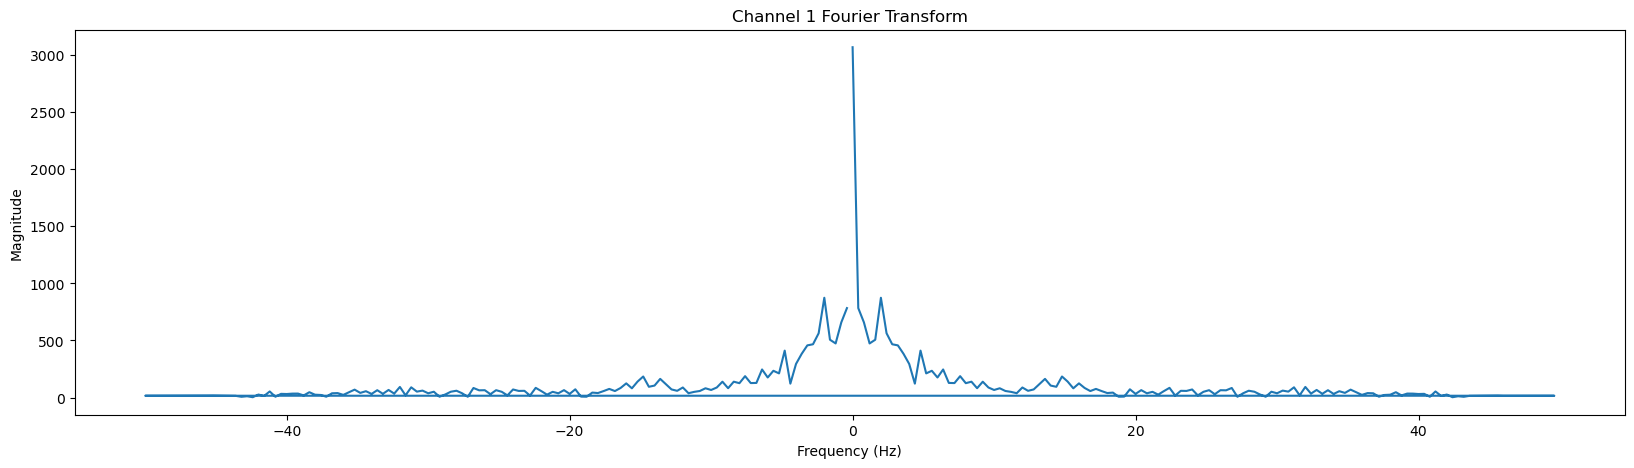

(250, 64)


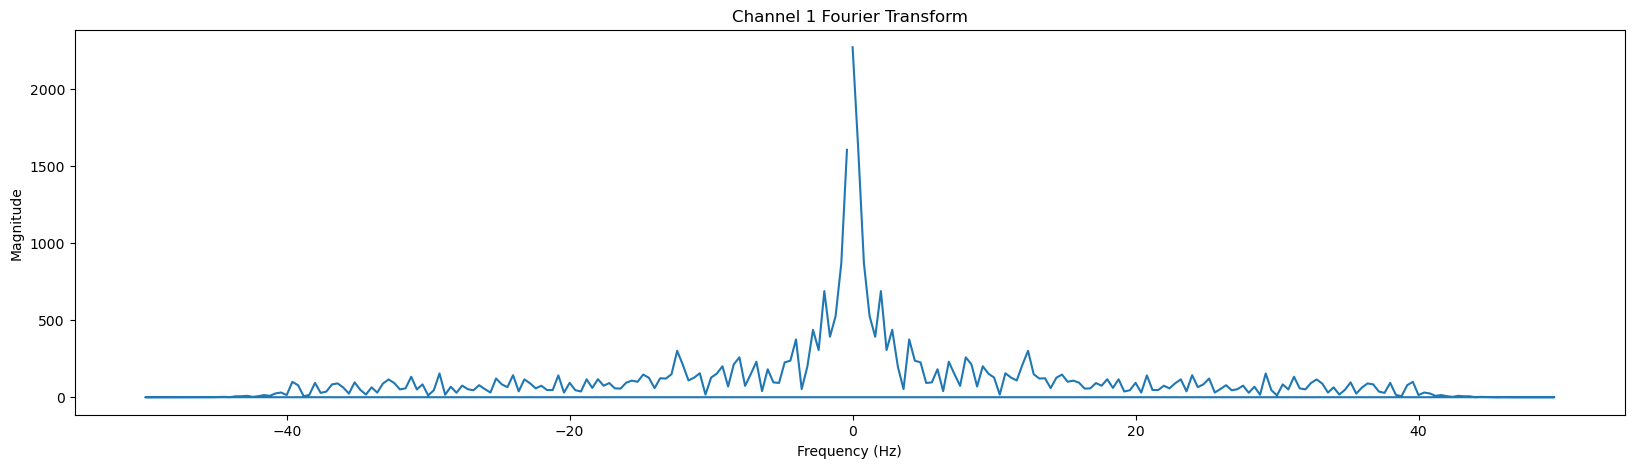

(250, 64)


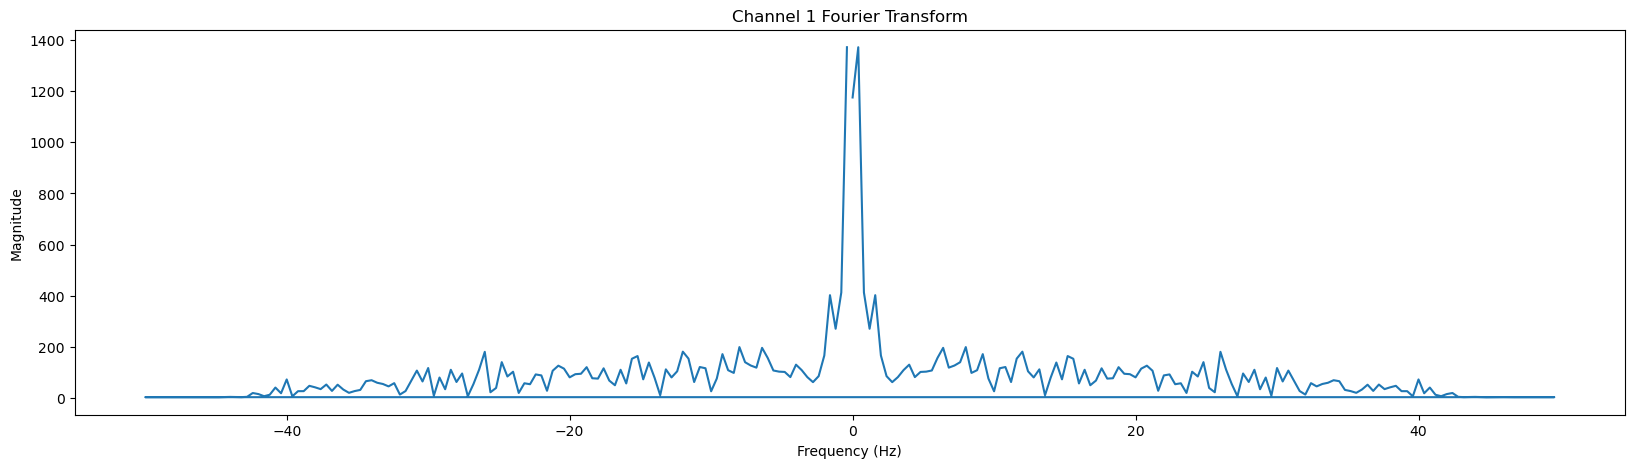

(250, 64)


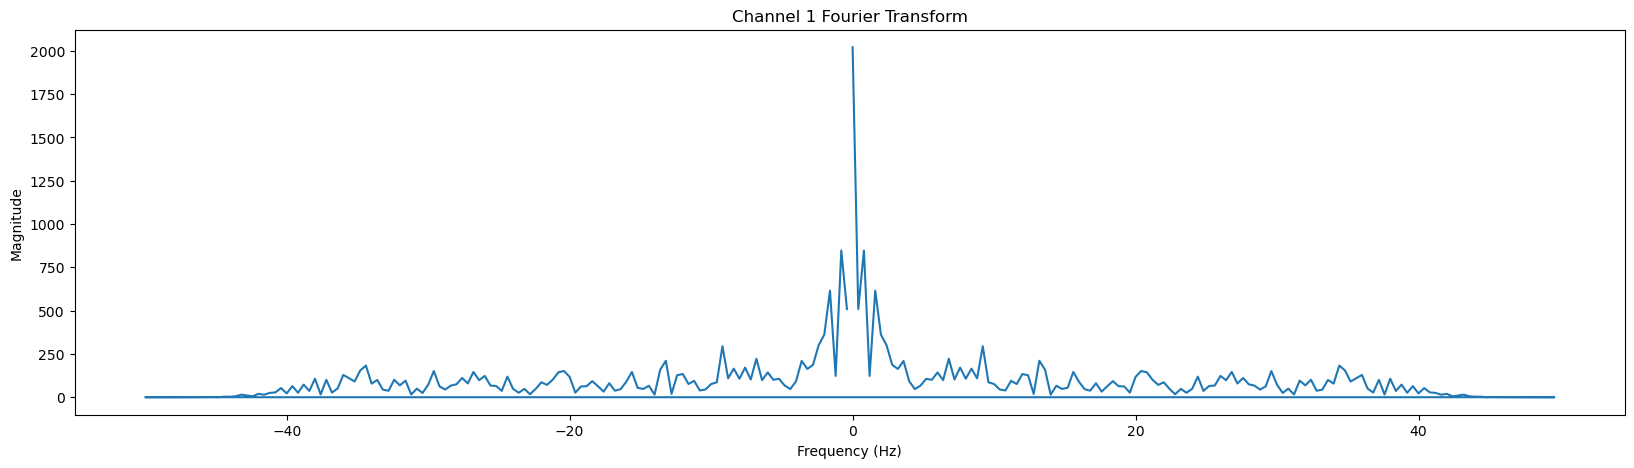

(250, 64)


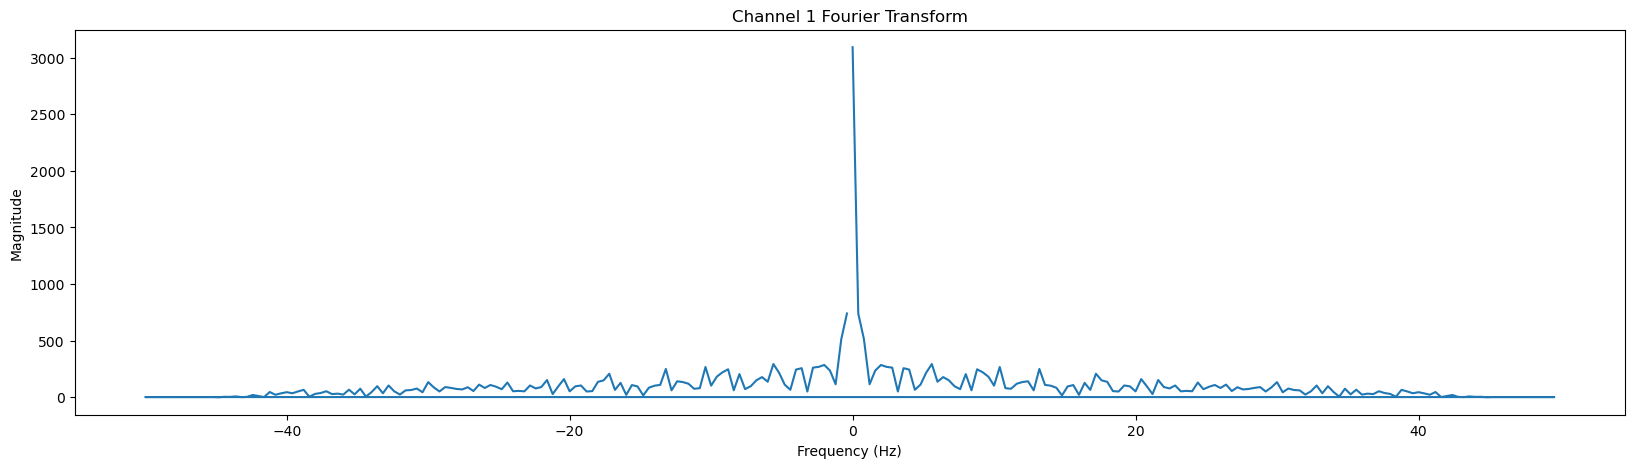

In [18]:
# in number of samples
window_size = 250
data = eeg

print("Number of windows in the data: ", data.shape[0] // window_size)

for count, i in enumerate(range(0, data.shape[0], window_size)):
    if count == 5:
        break
    # print(data.shape)
    window = data.iloc[i:i+window_size, :]
    window_time = time.iloc[i:i+window_size]
    # window_joints = j_walk[i:i+window_size]

    print(window.shape)

    channel_1 = window.iloc[:, 1]
    channel_1_f = lp(channel_1, 40)
    f, y = fourier_transform(channel_1_f, 100)

    plt.figure(figsize=(20, 5))
    plt.plot(f, np.abs(y))
    plt.title('Channel 1 Fourier Transform')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.show()

    # plt.figure(figsize=(20, 10))
    # plt.subplot(2, 1, 1)
    # plt.plot(window_time, window)
    # plt.title('Original EEG data')
    # plt.subplot(2, 1, 2)
    # plt.plot(window_time, window_ica)
    # plt.title('ICA EEG data')
    # plt.show()

    # plt.figure(figsize=(20, 10))
    # plt.subplot(2, 1, 1)
    # plt.plot(window_time, window_norm)
    # plt.title('Normalized EEG data')
    # plt.subplot(2, 1, 2)
    # plt.plot(window_time, window_reconstructed)
    # plt.title('Reconstructed EEG data')
    # plt.show()

    # plt.figure(figsize=(20, 10))
    # plt.plot(window_time, window_joints)
    # plt.title('Joint angles')
    # plt.show()

In [15]:
channel_1 = eeg[:, 1]
print(channel_1[0:10])
# print(time[1000:1010].shape, channel_1[1000:1010].shape)
print(time[0:10])

# print('Time interval: ', t_int_data)

# graph the first channel vs time with walking highlighted


[ 0.   0.   0.   0.   0.   0.  23.5 22.8 23.5 22.8]
[0.139 0.142 0.153 0.163 0.174 0.184 0.194 0.205 0.215 0.226]


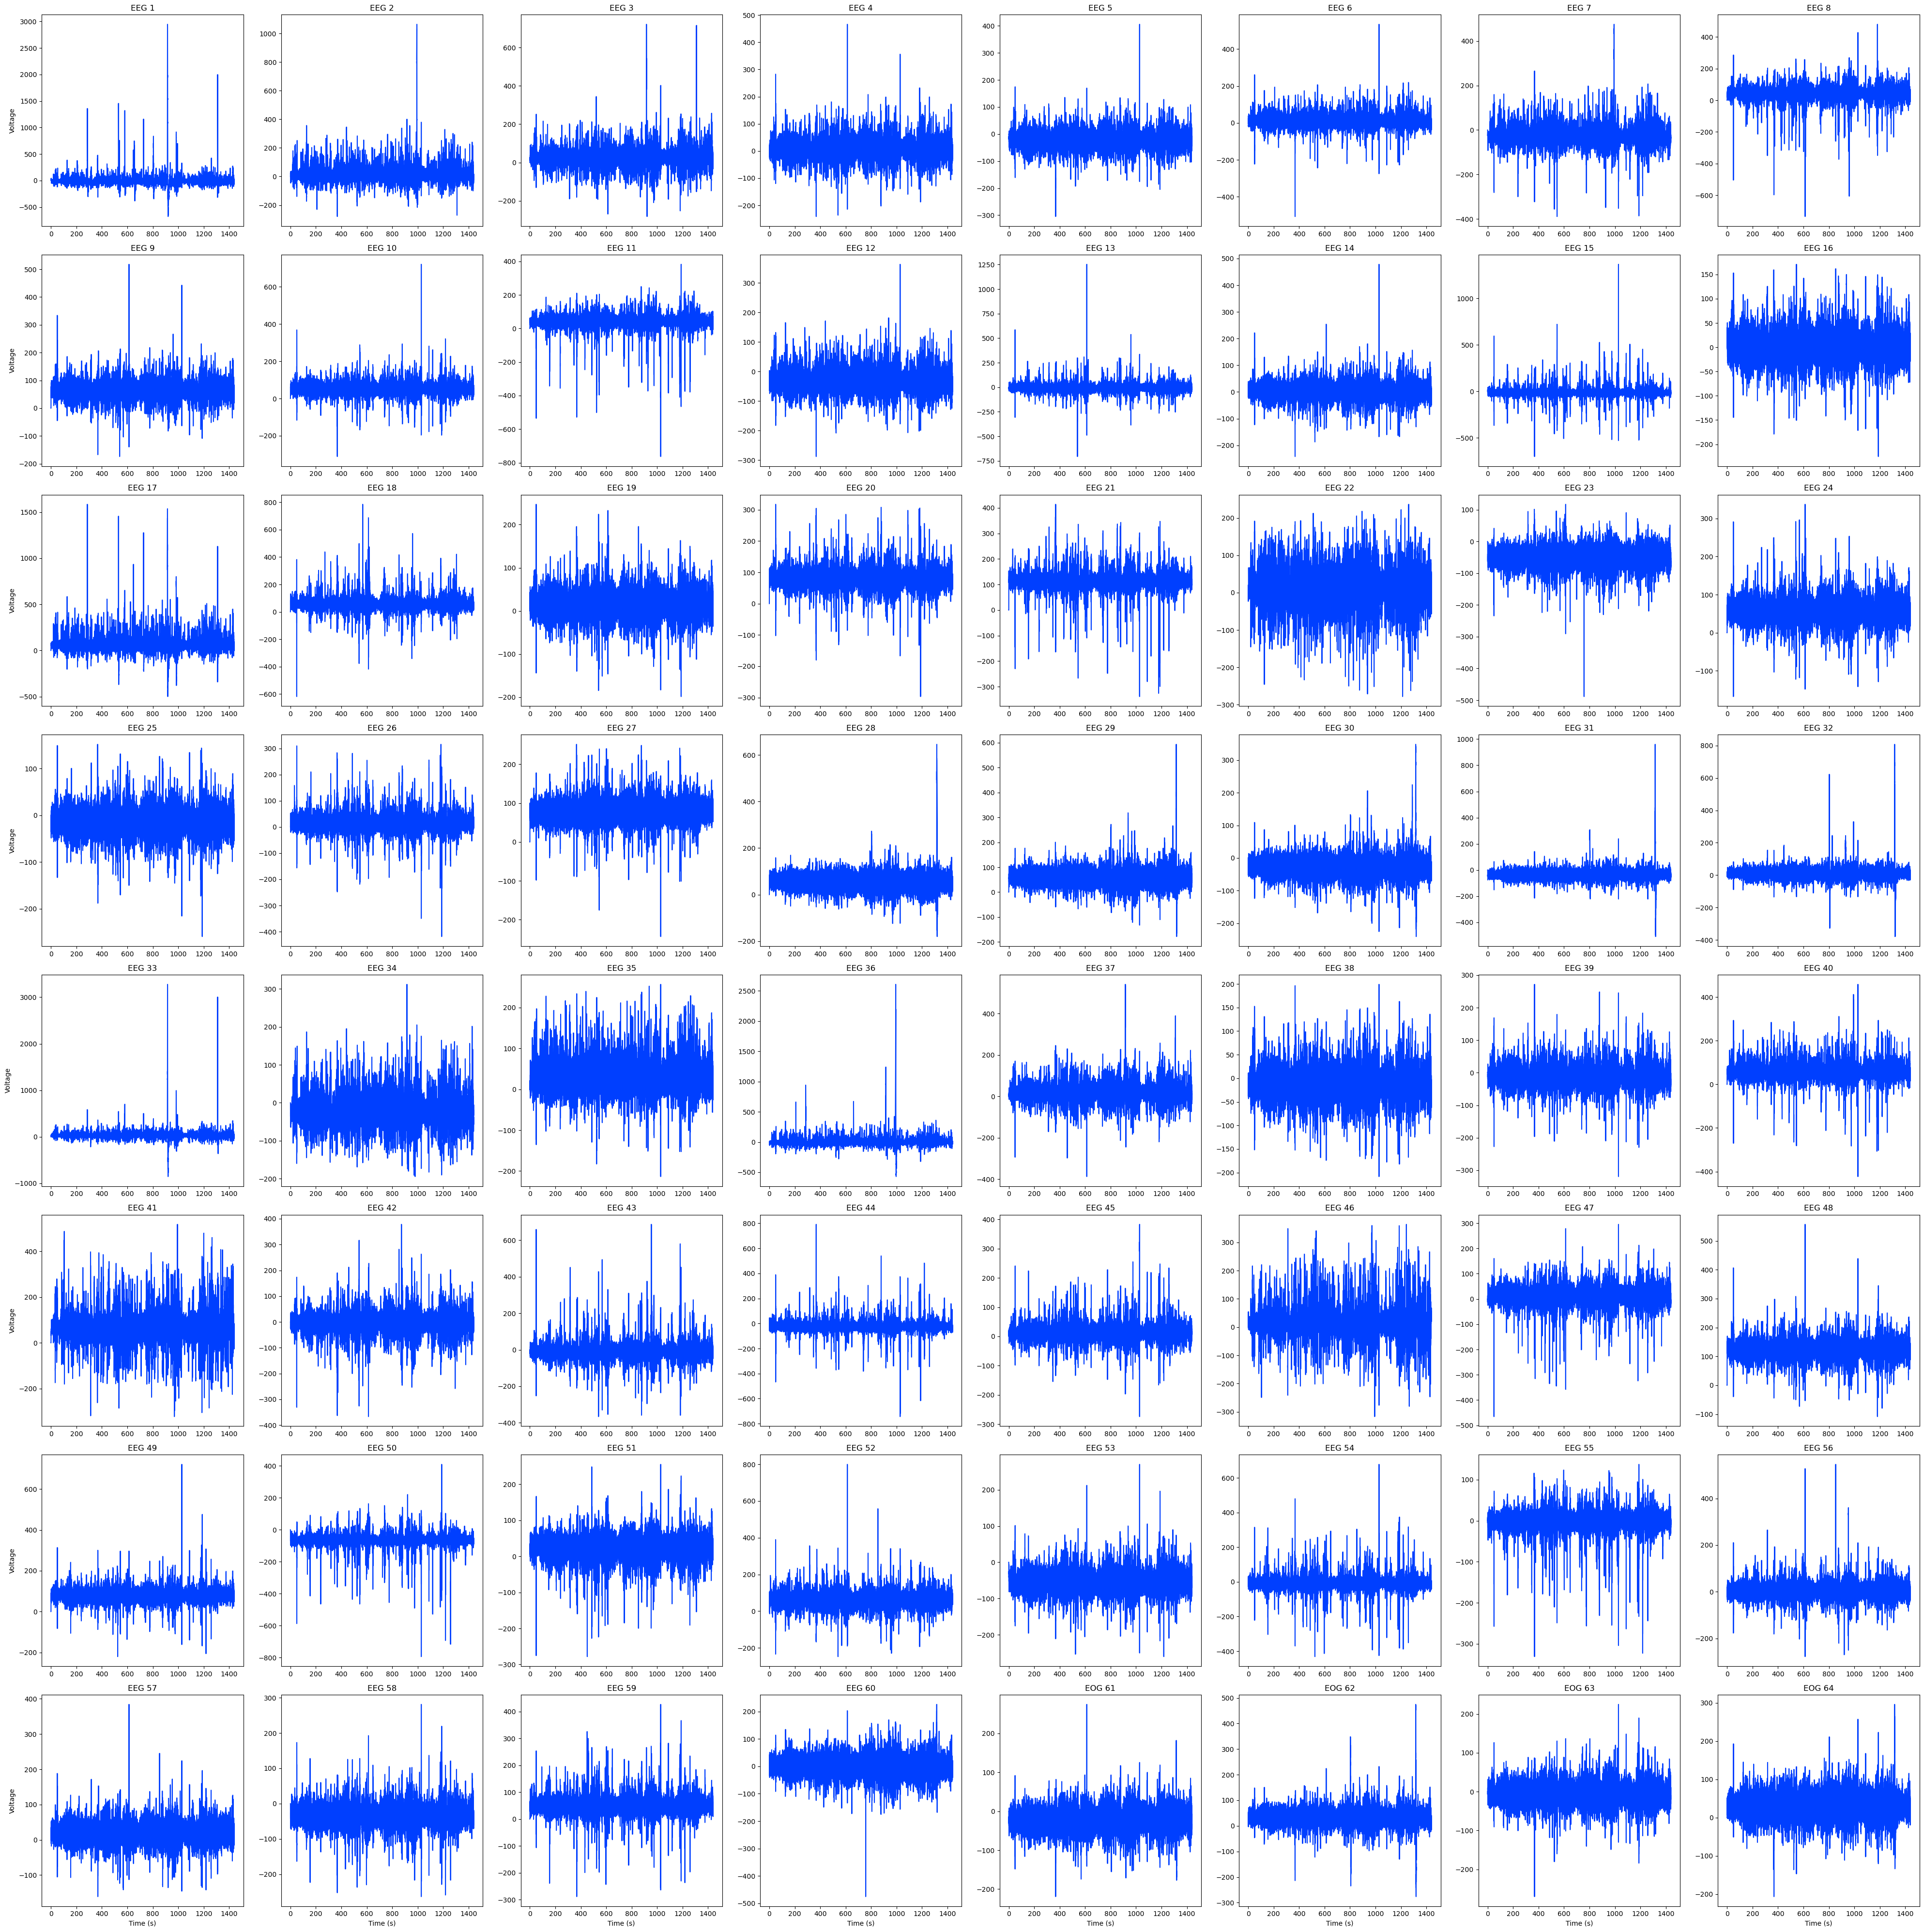

In [16]:
# plot 64 channels in 8x8 grid, label the last 4 channels as EOG, and first 60 as EEG
def visualize_subject_eeg(eeg, time):
    fig, axs = plt.subplots(8, 8, figsize=(40, 40))
    for i in range(8):
        for j in range(8):
            axs[i, j].plot(time, eeg[:, i * 8 + j])
            if i == 7:
                axs[i, j].set_xlabel('Time (s)')
            if j == 0:
                axs[i, j].set_ylabel('Voltage')
            if i * 8 + j < 60:
                axs[i, j].set_title('EEG ' + str(i * 8 + j + 1))
            else:
                axs[i, j].set_title('EOG ' + str(i * 8 + j + 1))
    plt.tight_layout()
    plt.show()

visualize_subject_eeg(eeg, time)

In [59]:
def butter_lowpass(cutoff, fs, order=5):
    return sig.butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = sig.lfilter(b, a, data)
    return y

loop: 0
loop: 1
loop: 2
loop: 3
loop: 4


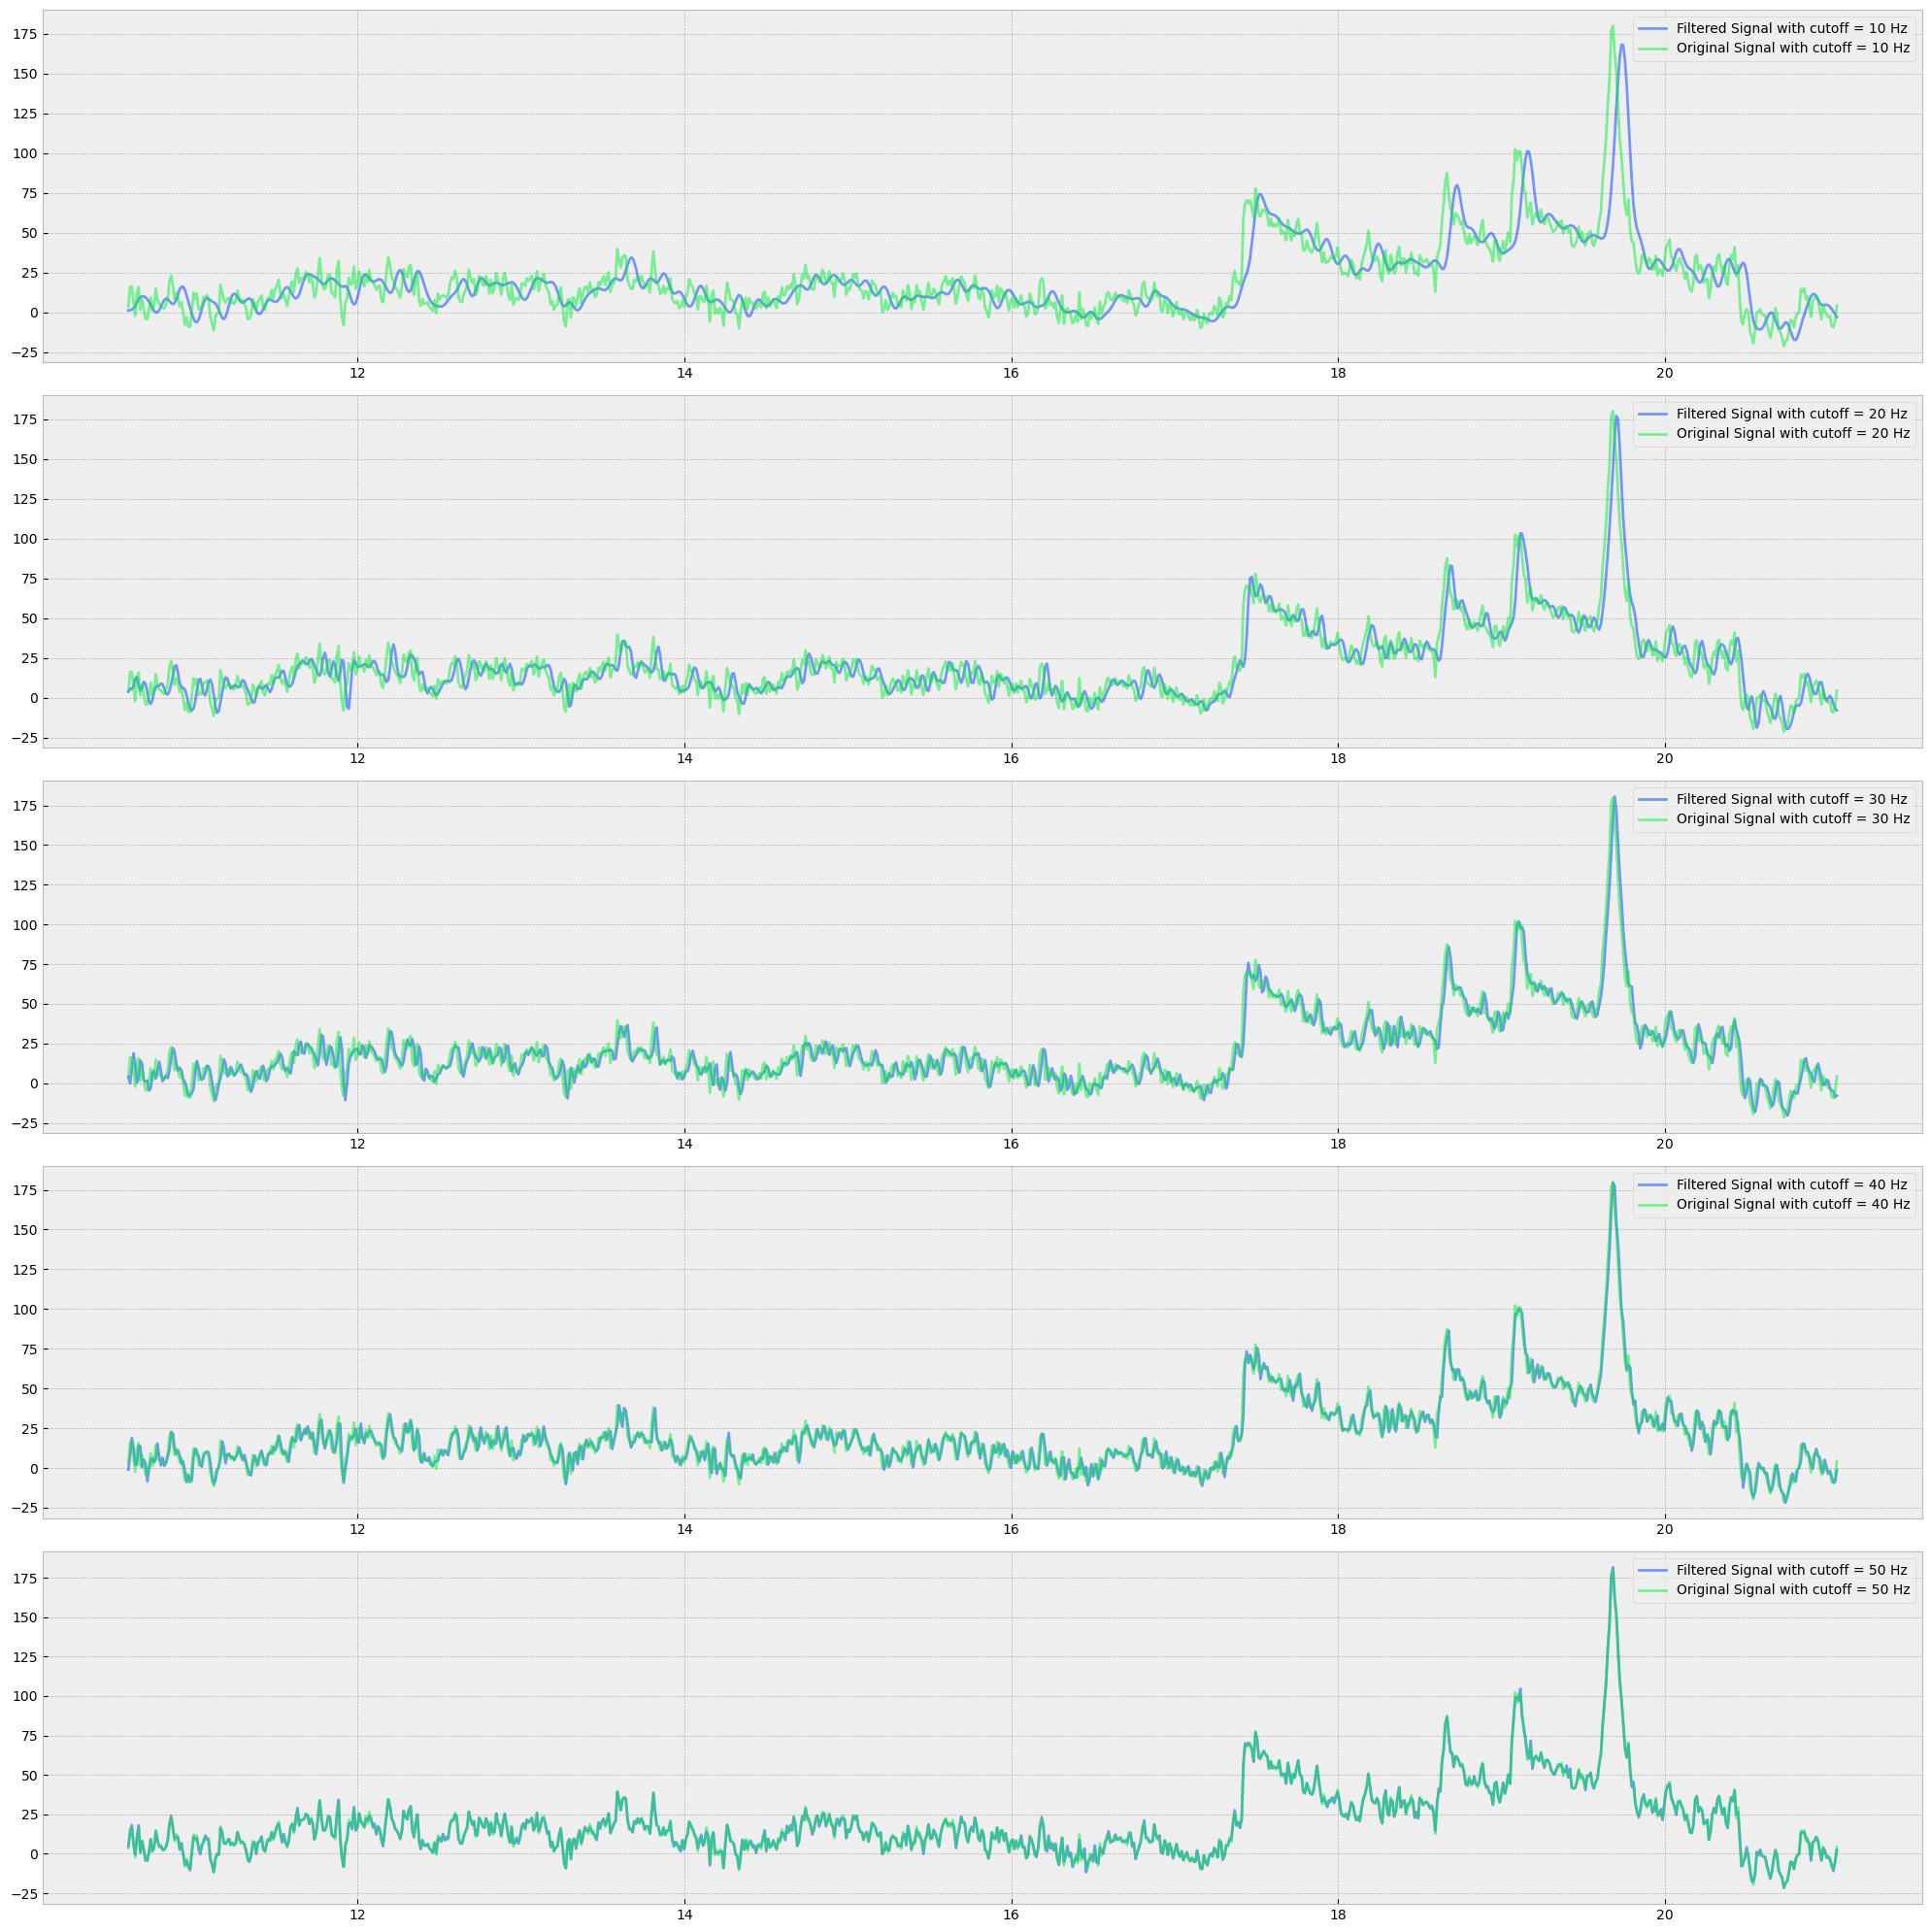

In [100]:
def lp(data, fc): # filter out all freq above 50 with 
    return butter_lowpass_filter(data=data, cutoff=fc, fs=100)

# y = lp(channel_1, 40)
figsize = (20, 20)

fig, axs = plt.subplots(5, 1, figsize=figsize)

for i in range (1, 6):
    index=i-1
    print(f"loop: {index}")
    y = eeg[:, 1]
    y_f = lp(y, i * 10) if i != 5 else lp(y, 49)
    axs[index].plot(time[1000:2000], y_f[1000:2000], alpha=.5, label=f"Filtered Signal with cutoff = {i*10} Hz")
    axs[index].plot(time[1000:2000], y[1000:2000], alpha=.5, label=f"Original Signal with cutoff = {i*10} Hz")
    axs[index].set_xlabel('Time (s)') if index == 5 else None
    axs[index].legend()

plt.tight_layout()
plt.show()

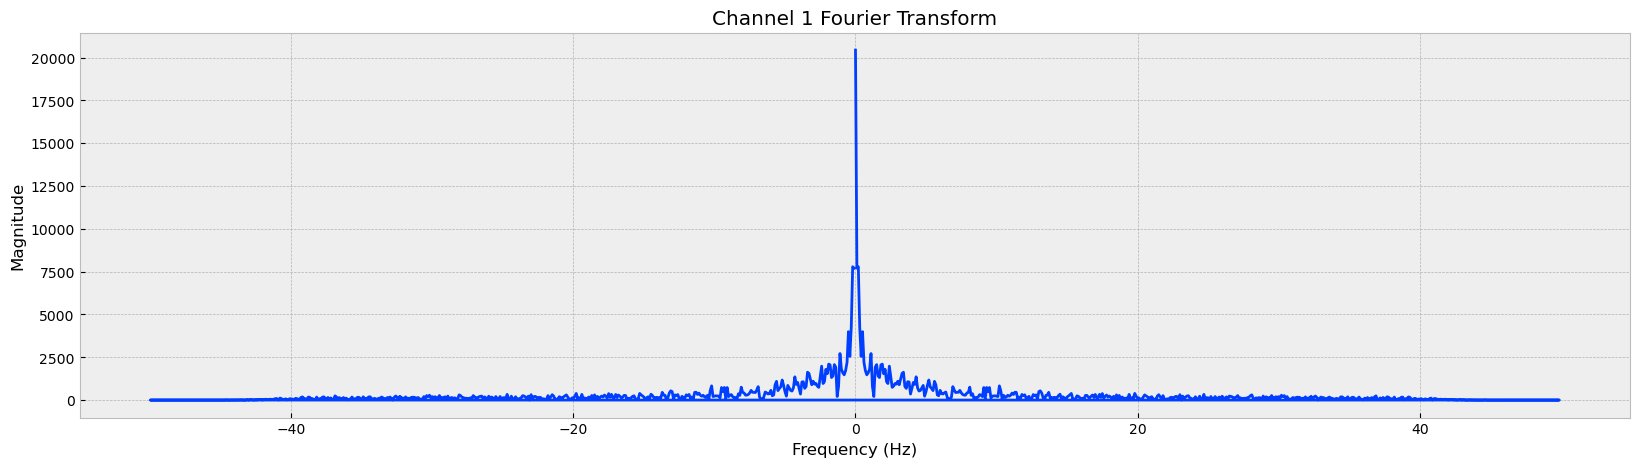

In [106]:
# use fourier transform to get the signal in frequency domain
def fourier_transform(data, fs):
    n = len(data)
    f = np.fft.fftfreq(n, 1/fs)
    y = np.fft.fft(data)
    return f, y

channel_1 = eeg[:, 1]

# filter the signal
channel_1_f = lp(channel_1, 40)
# get the fourier transform
f, y = fourier_transform(channel_1_f[1000:2000], 100)

plt.figure(figsize=(20, 5))
plt.plot(f, np.abs(y))
plt.title('Channel 1 Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

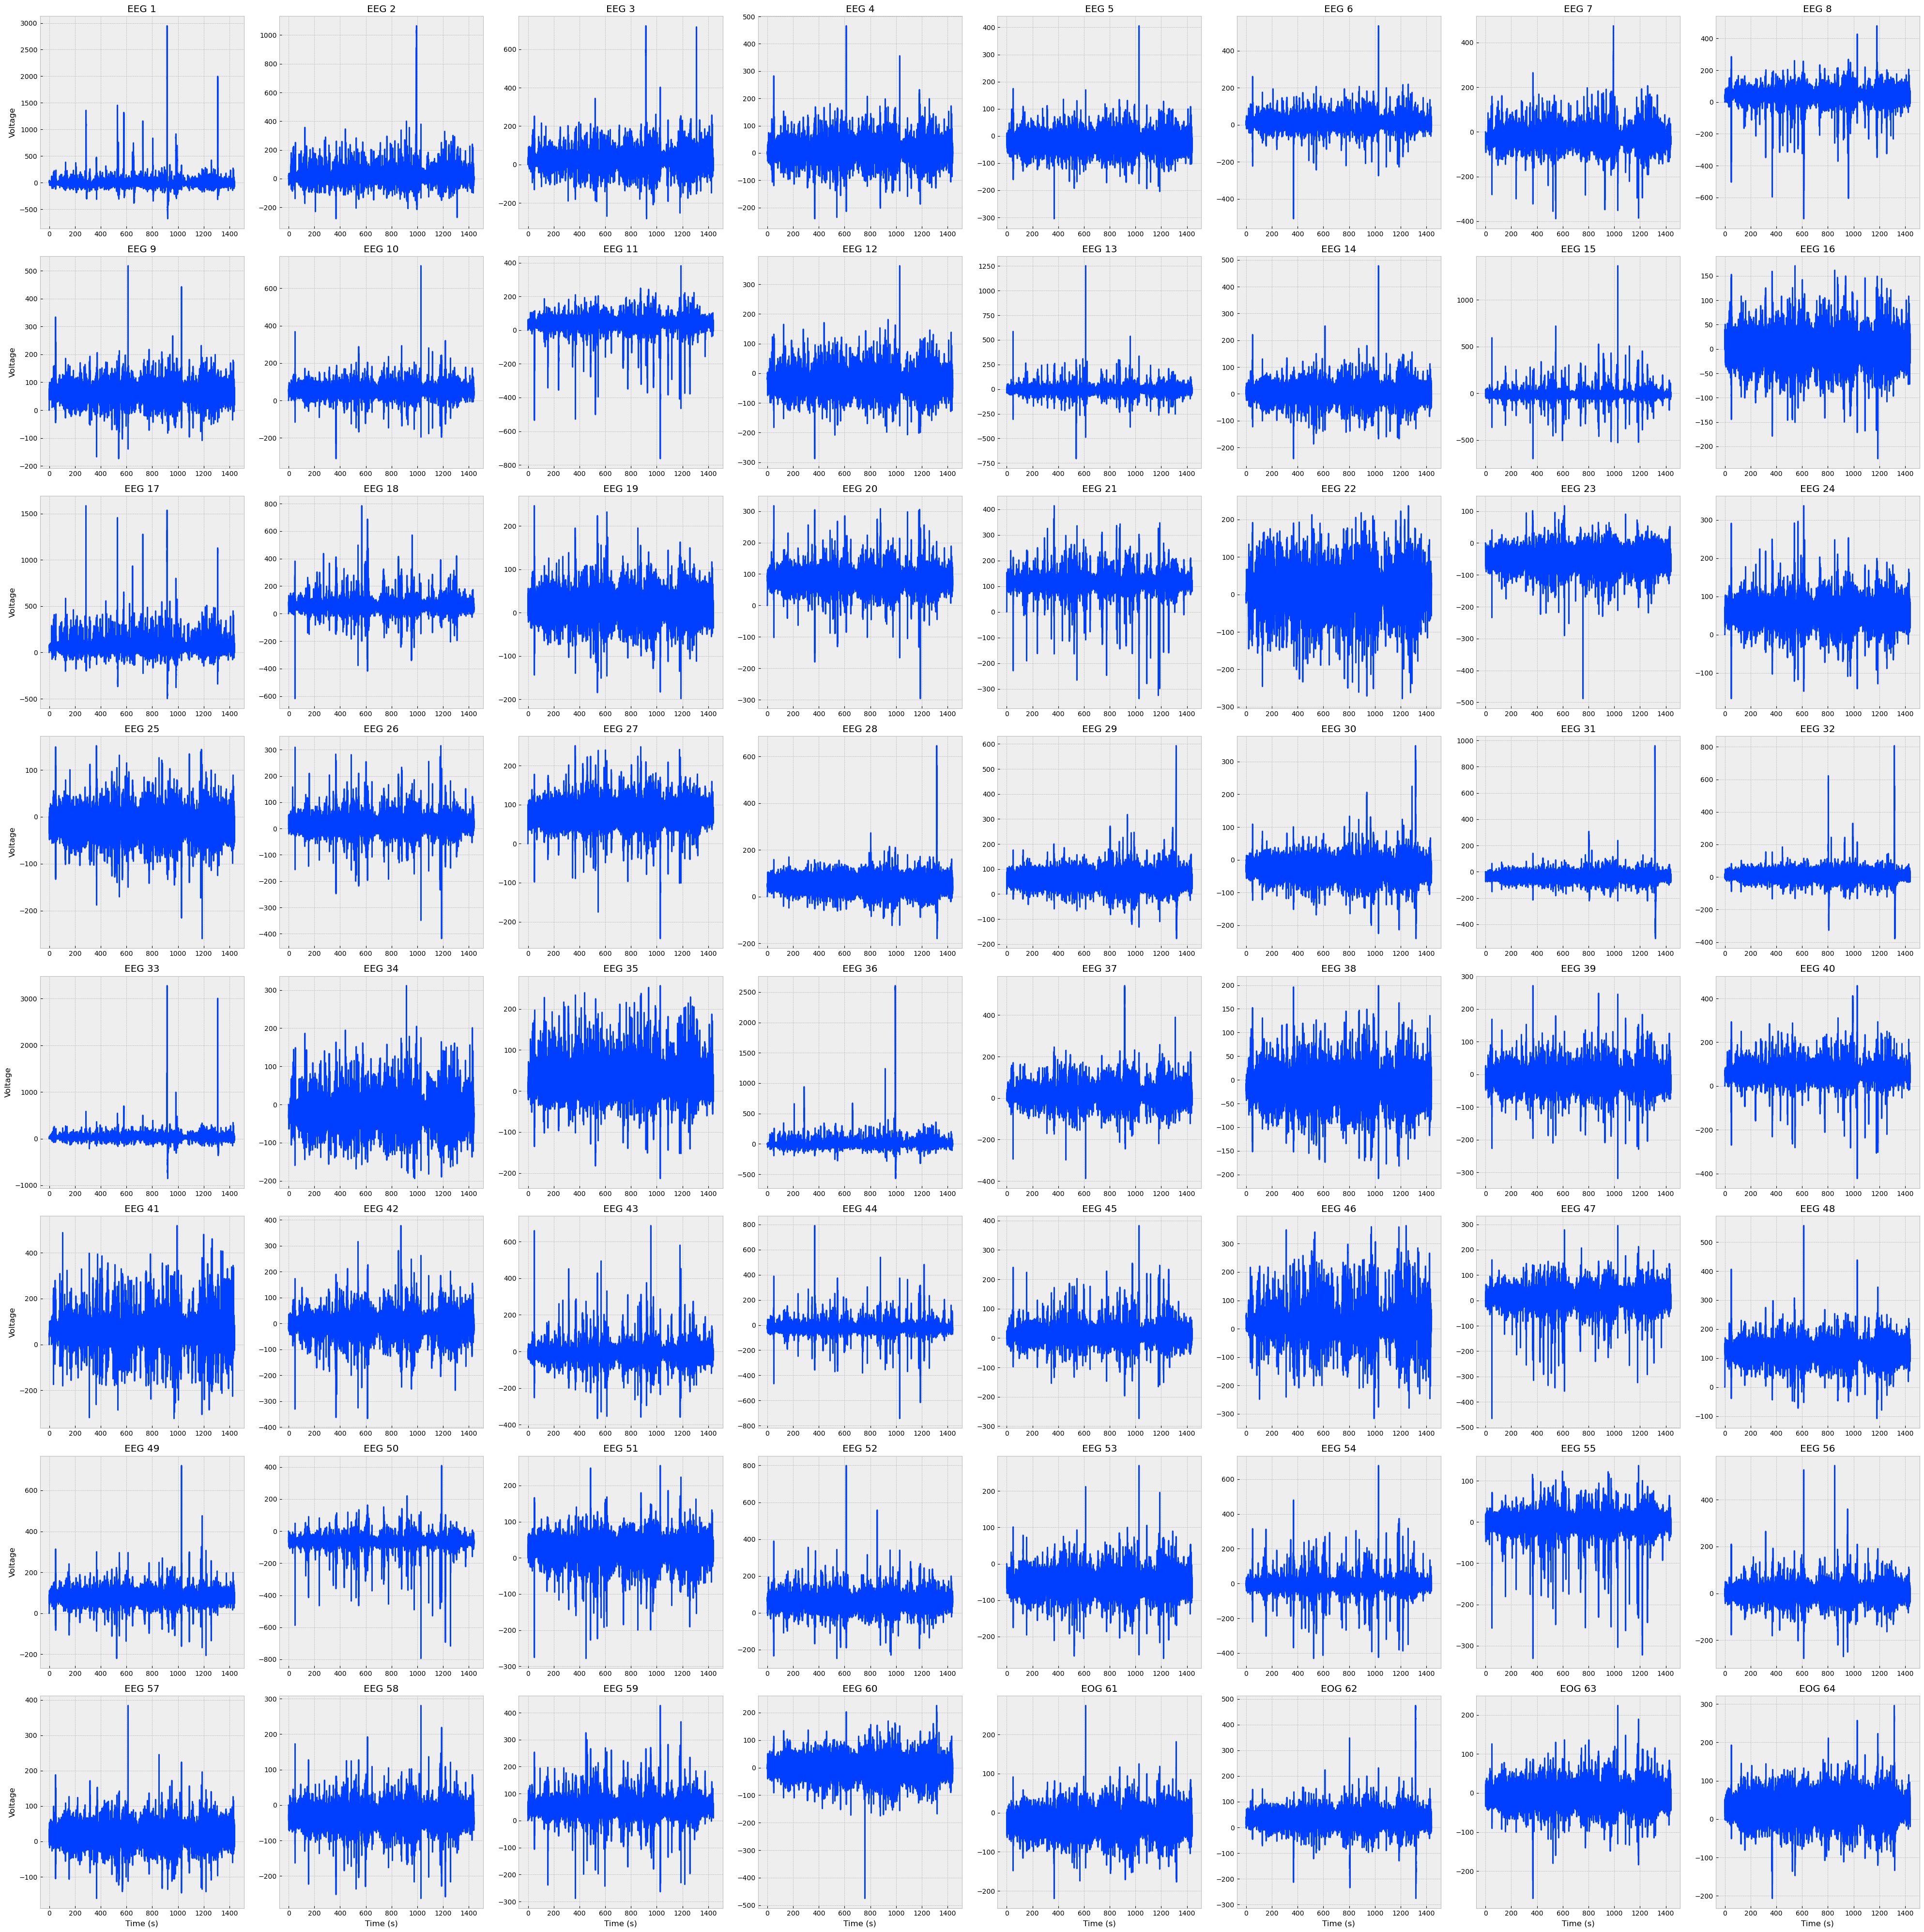

In [63]:
def visualize_subject_eeg_flt(eeg, time):

    eeg_f = lp_50(eeg)
    fig, axs = plt.subplots(8, 8, figsize=(40, 40))
    for i in range(8):
        for j in range(8):
            # axs[i, j].plot(time, eeg[:, i * 8 + j], label="o", alpha=.3)
            axs[i, j].plot(time, eeg_f[:, i * 8 + j], label="f", alpha=.3)
            if i == 7:
                axs[i, j].set_xlabel('Time (s)')
            if j == 0:
                axs[i, j].set_ylabel('Voltage')
            if i * 8 + j < 60:
                axs[i, j].set_title('EEG ' + str(i * 8 + j + 1))
            else:
                axs[i, j].set_title('EOG ' + str(i * 8 + j + 1))
    plt.tight_layout()
    plt.legend()
    plt.show()

visualize_subject_eeg(eeg, time)